In [1]:
#I am connecting collab notebook to my google drive where all the content and style images are stored
import pandas as pd
import numpy as np

from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
%cd /content/drive/My Drive/


/content/drive/My Drive


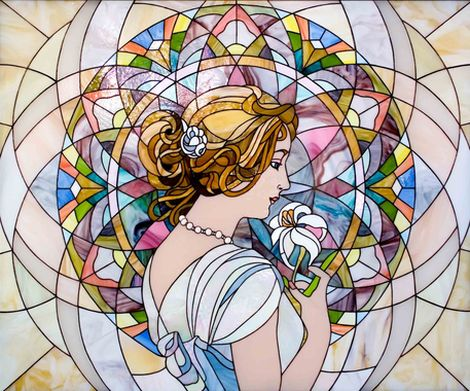

In [3]:
import cv2
from google.colab.patches import cv2_imshow

# Open the image.
img = cv2.imread("dashtoon_data/style-images/mosaic.jpg")
cv2_imshow(img)

In [4]:
!pip install utils

In [5]:
# Specify the directory containing the requirements.txt file
directory_path = 'dashtoon_data/'

# Change the current working directory
os.chdir(directory_path)
!pip install -r requirements.txt

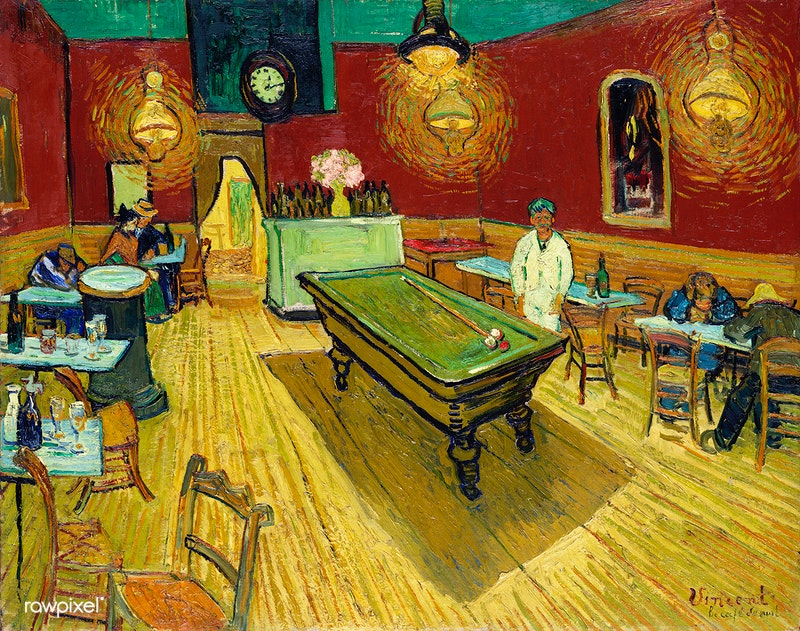

In [ ]:
# Open the image.
img = cv2.imread("style-images/vg_la_cafe.jpg")
cv2_imshow(img)

In [7]:
from __future__ import division
from torchvision import models
from torchvision import transforms
from PIL import Image
import argparse
import torch
import torchvision
import torch.nn as nn
import numpy as np


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

content_image='content-images/green_bridge.jpg'
style_image='style-images/vg_la_cafe.jpg'
max_size=400
total_step=2000
log_step=10
sample_step=500
style_weight=100
lr=0.003

def load_image(image_path, transform=None, max_size=None, shape=None):
    """Load an image and convert it to a torch tensor."""
    image = Image.open(image_path)

    if max_size:
        scale = max_size / max(image.size)
        size = np.array(image.size) * scale
        image = image.resize(size.astype(int), Image.ANTIALIAS)

    if shape:
        image = image.resize(shape, Image.LANCZOS)

    if transform:
        image = transform(image).unsqueeze(0)

    return image.to(device)


class VGGNet(nn.Module):
    def __init__(self):
        """Select conv1_1 ~ conv5_1 activation maps."""
        super(VGGNet, self).__init__()
        self.select = ['0', '5', '10', '19', '28']
        self.vgg = models.vgg19(pretrained=True).features

    def forward(self, x):
        """Extract multiple convolutional feature maps."""
        features = []
        for name, layer in self.vgg._modules.items():
            x = layer(x)
            if name in self.select:
                features.append(x)
        return features


def cal():

    # Image preprocessing
    # VGGNet was trained on ImageNet where images are normalized by mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].
    # We use the same normalization statistics here.
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406),
                             std=(0.229, 0.224, 0.225))])

    # Load content and style images
    # Make the style image same size as the content image
    content = load_image(content_image, transform, max_size=max_size)
    style = load_image(style_image, transform, shape=[content.size(2), content.size(3)])

    # Initialize a target image with the content image
    target = content.clone().requires_grad_(True)

    optimizer = torch.optim.Adam([target], lr=lr, betas=[0.5, 0.999])
    vgg = VGGNet().to(device).eval()

    for step in range(total_step):

        # Extract multiple(5) conv feature vectors
        target_features = vgg(target)
        content_features = vgg(content)
        style_features = vgg(style)

        style_loss = 0
        content_loss = 0
        for f1, f2, f3 in zip(target_features, content_features, style_features):
            # Compute content loss with target and content images
            content_loss += torch.mean((f1 - f2)**2)

            # Reshape convolutional feature maps
            _, c, h, w = f1.size()
            f1 = f1.view(c, h * w)
            f3 = f3.view(c, h * w)

            # Compute gram matrix
            f1 = torch.mm(f1, f1.t())
            f3 = torch.mm(f3, f3.t())

            # Compute style loss with target and style images
            style_loss += torch.mean((f1 - f3)**2) / (c * h * w)

        # Compute total loss, backprop and optimize
        loss = content_loss + style_weight * style_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (step+1) % log_step == 0:
            print ('Step [{}/{}], Content Loss: {:.4f}, Style Loss: {:.4f}'
                   .format(step+1, total_step, content_loss.item(), style_loss.item()))

        if (step+1) % sample_step == 0:
            # Save the generated image
            denorm = transforms.Normalize((-2.12, -2.04, -1.80), (4.37, 4.46, 4.44))
            img = target.clone().squeeze()
            img = denorm(img).clamp_(0, 1)
            torchvision.utils.save_image(img, 'output-{}.png'.format(step+1))


if __name__ == "__main__":
    cal()

<ipython-input-7-fb4983fda127>:31: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize(size.astype(int), Image.ANTIALIAS)


Step [10/2000], Content Loss: 4.5465, Style Loss: 732.6754
Step [20/2000], Content Loss: 12.0797, Style Loss: 500.9457
Step [30/2000], Content Loss: 16.5938, Style Loss: 365.5623
Step [40/2000], Content Loss: 19.3864, Style Loss: 286.1439
Step [50/2000], Content Loss: 21.3683, Style Loss: 234.9733
Step [60/2000], Content Loss: 22.8932, Style Loss: 200.3551
Step [70/2000], Content Loss: 24.1053, Style Loss: 175.9405
Step [80/2000], Content Loss: 25.0733, Style Loss: 157.9669
Step [90/2000], Content Loss: 25.8855, Style Loss: 144.1257
Step [100/2000], Content Loss: 26.5769, Style Loss: 133.0619
Step [110/2000], Content Loss: 27.1878, Style Loss: 123.9494
Step [120/2000], Content Loss: 27.7271, Style Loss: 116.2516
Step [130/2000], Content Loss: 28.2096, Style Loss: 109.6330
Step [140/2000], Content Loss: 28.6508, Style Loss: 103.8697
Step [150/2000], Content Loss: 29.0647, Style Loss: 98.7619
Step [160/2000], Content Loss: 29.4507, Style Loss: 94.2092
Step [170/2000], Content Loss: 29.81

In [ ]:
import cv2
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

# Read the images
image1 = cv2.imread(content_image)
image2 = cv2.imread(style_image)

# Resize images if needed
# image1 = cv2.resize(image1, (width, height))
# image2 = cv2.resize(image2, (width, height))

# Check and adjust the dimensions and type of the images
if image1.shape[0] != image2.shape[0] or image1.shape[2] != image2.shape[2]:
    min_height = min(image1.shape[0], image2.shape[0])
    min_channels = min(image1.shape[2], image2.shape[2])
    image1 = image1[:min_height, :, :min_channels]
    image2 = image2[:min_height, :, :min_channels]

# Concatenate the images horizontally
result = cv2.hconcat([image1, image2])

# Display the result using cv2_imshow
cv2_imshow(result)
